Loading data...
Creating patient-level dataset...

=== Quick EDA ===
Number of patients: 48
Health risk distribution (counts):
health_risk
1    33
0    15
Name: count, dtype: int64

Some numeric summaries:
                           count         mean         std      min  \
total_treatments            48.0     4.166667    1.894374    2.000   
avg_treatment_cost          48.0  2781.683022  773.275909  868.345   
max_treatment_cost          48.0  3996.895625  916.038110  929.910   
days_since_last_treatment   48.0    94.229167   82.800257    0.000   

                                   25%       50%          75%      max  
total_treatments              3.000000     4.000     5.000000    10.00  
avg_treatment_cost         2241.612917  2682.425  3300.380208  4662.05  
max_treatment_cost         3538.812500  4172.395  4732.562500  4973.63  
days_since_last_treatment    31.000000    63.500   142.250000   307.00  

Nulls per feature:
total_treatments             0.0
avg_treatment_cost       

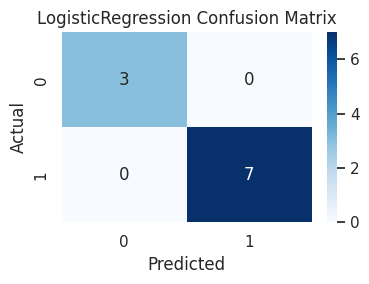

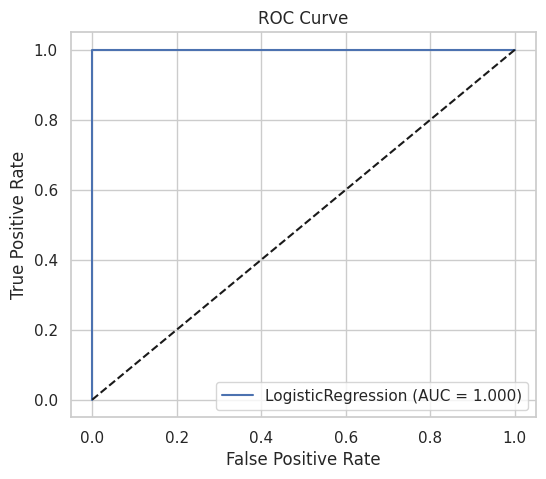


Training RandomForest ... (this may take a while for SVM/XGBoost)

--- RandomForest Evaluation ---
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000
ROC-AUC:   1.0000

Confusion matrix:
[[3 0]
 [0 7]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



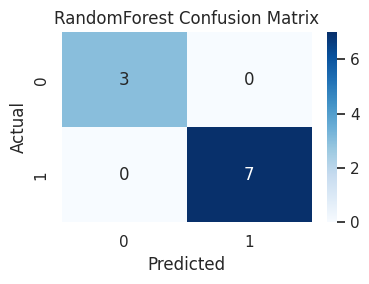

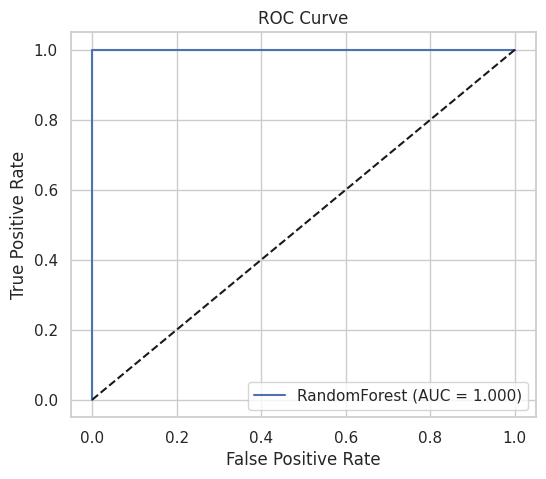


Training XGBoost ... (this may take a while for SVM/XGBoost)

--- XGBoost Evaluation ---
Accuracy:  0.9000
Precision: 1.0000
Recall:    0.8571
F1-score:  0.9231
ROC-AUC:   1.0000

Confusion matrix:
[[3 0]
 [1 6]]

Classification report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.86      0.92         7

    accuracy                           0.90        10
   macro avg       0.88      0.93      0.89        10
weighted avg       0.93      0.90      0.90        10



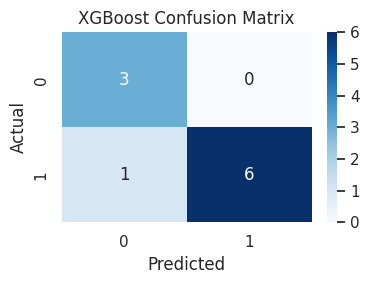

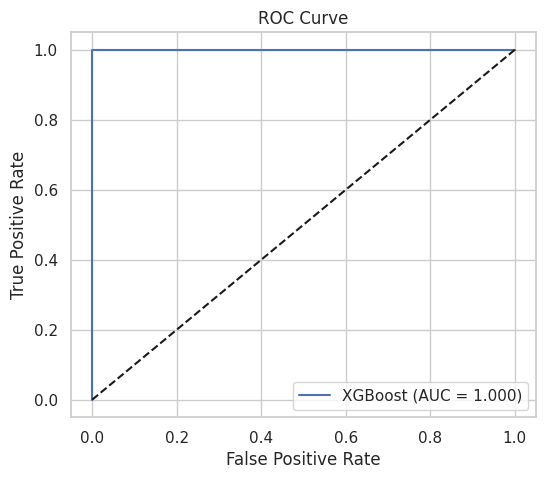


Training SVM ... (this may take a while for SVM/XGBoost)

--- SVM Evaluation ---
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000
ROC-AUC:   1.0000

Confusion matrix:
[[3 0]
 [0 7]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



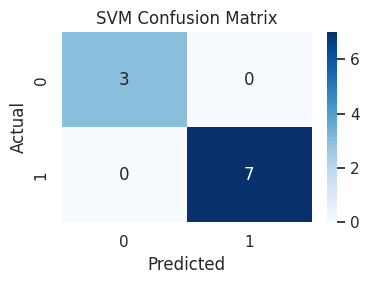

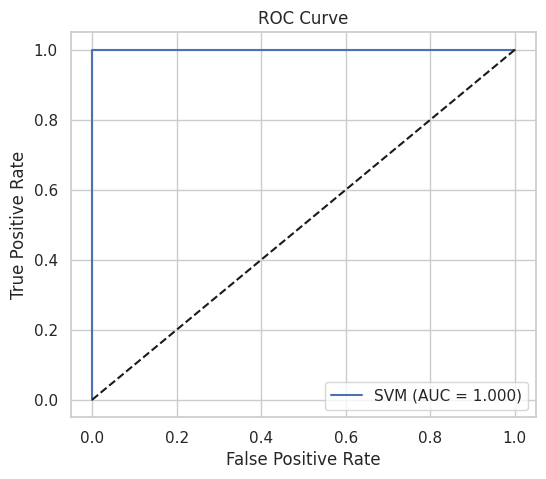


Best model by recall: LogisticRegression
Saved best model pipeline to 'best_model.joblib'

Feature importances (if available):
Best model does not expose feature_importances_. Showing MI instead:
high_cost_flag_1              0.318788
high_cost_flag_0              0.317860
frequent_treatments_flag_1    0.254075
avg_treatment_cost            0.229482
max_treatment_cost            0.218518
recent_treatment_flag_0       0.196583
days_since_last_treatment     0.161481
total_treatments              0.151746
frequent_treatments_flag_0    0.118058
gender_M                      0.075627
recent_treatment_flag_1       0.028543
chronic_flag_0                0.000000
gender_F                      0.000000
dtype: float64

=== Summary table (models sorted by recall) ===
| model              |   accuracy |   precision |   recall |       f1 |   roc_auc |
|:-------------------|-----------:|------------:|---------:|---------:|----------:|
| LogisticRegression |        1   |           1 | 1        | 1  

In [3]:
import zipfile
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')


from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42



# Helper functions (student-style)

def load_data_from_zip(zip_path='archive.zip'):
    """Load CSVs from a zip (appointments, treatments, patients, doctors, billing)."""
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Cannot find {zip_path} in working directory.")
    with zipfile.ZipFile(zip_path, 'r') as z:
        # read only the files we expect; if missing, raise a helpful message
        names = z.namelist()
        needed = ['appointments.csv', 'treatments.csv', 'patients.csv']
        for n in needed:
            if n not in names:
                raise ValueError(f"Missing {n} inside {zip_path} — please check upload.")
        appts = pd.read_csv(z.open('appointments.csv'))
        treats = pd.read_csv(z.open('treatments.csv'))
        pats = pd.read_csv(z.open('patients.csv'))
        # optional files
        docs = pd.read_csv(z.open('doctors.csv')) if 'doctors.csv' in names else pd.DataFrame()
        bill = pd.read_csv(z.open('billing.csv')) if 'billing.csv' in names else pd.DataFrame()
    return appts, treats, pats, docs, bill


def create_patient_level_dataset(appts, treats, pats):
    """
    Merge treatments + appointments + patients into a patient-level table with features.
    We will create a proxy binary target 'health_risk'.
    """
    # merge appointment info into treatments
    df = treats.merge(
        appts[['appointment_id', 'patient_id', 'appointment_date', 'reason_for_visit', 'status']],
        on='appointment_id', how='left'
    )
    df = df.merge(pats, on='patient_id', how='left')

    # parse dates (if they exist)
    for col in ['treatment_date', 'appointment_date']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # patient-level aggregations
    agg = df.groupby('patient_id').agg(
        total_treatments=('treatment_id', 'count'),
        avg_treatment_cost=('cost', 'mean'),
        max_treatment_cost=('cost', 'max'),
        last_treatment_date=('treatment_date', 'max')
    ).reset_index()

    # days since last treatment (use dataset max as reference)
    if 'treatment_date' in df.columns and not df['treatment_date'].isnull().all():
        max_date = df['treatment_date'].max()
        agg['days_since_last_treatment'] = (max_date - agg['last_treatment_date']).dt.days.fillna(9999).astype(int)
    else:
        agg['days_since_last_treatment'] = 9999

    # detect chronic conditions heuristically (scan patient text fields for keywords)
    pats_text = pats.fillna('').astype(str)
    chronic_keywords = ['diabetes', 'hypertension', 'asthma', 'cancer', 'hiv', 'tb', 'tuberculosis', 'cardiac', 'heart']
    pats['chronic_flag'] = 0
    # check several patient columns (name, notes, diagnosis-like columns)
    for col in pats_text.columns:
        mask = pats_text[col].str.lower().str.contains('|'.join(chronic_keywords), na=False)
        if mask.any():
            pats.loc[mask, 'chronic_flag'] = 1

    # merge chronic_flag & demographics into agg
    merge_cols = ['patient_id', 'chronic_flag']
    # try to also get gender and age if they exist
    extra = []
    if 'gender' in pats.columns:
        extra.append('gender')
    if 'age' in pats.columns:
        extra.append('age')
    if extra:
        merge_cols += extra
    agg = agg.merge(pats[merge_cols], on='patient_id', how='left')

    # derived flags
    agg['avg_treatment_cost'] = agg['avg_treatment_cost'].fillna(0)
    agg['high_cost_flag'] = (agg['avg_treatment_cost'] > agg['avg_treatment_cost'].median()).astype(int)
    agg['frequent_treatments_flag'] = (agg['total_treatments'] > agg['total_treatments'].median()).astype(int)
    agg['recent_treatment_flag'] = (agg['days_since_last_treatment'] <= 30).astype(int)

    # proxy target: HIGH risk if any of chronic, frequent treatments, or high cost
    agg['health_risk'] = ((agg['chronic_flag'] == 1) | (agg['frequent_treatments_flag'] == 1) | (agg['high_cost_flag'] == 1)).astype(int)

    # tidy: fill missing gender/age with sensible defaults
    if 'gender' in agg.columns:
        agg['gender'] = agg['gender'].fillna('Unknown').astype(str)
    if 'age' in agg.columns:
        agg['age'] = pd.to_numeric(agg['age'], errors='coerce')

    #patient-level dataframe
    return agg


def quick_eda(df):
    """Print a few quick exploration lines for the submission/report."""
    print("\n=== Quick EDA ===")
    print("Number of patients:", df['patient_id'].nunique())
    print("Health risk distribution (counts):")
    print(df['health_risk'].value_counts(dropna=False))
    print("\nSome numeric summaries:")
    print(df[['total_treatments', 'avg_treatment_cost', 'max_treatment_cost', 'days_since_last_treatment']].describe().T)


def build_preprocessor(numeric_features, categorical_features):
    """Return a ColumnTransformer for numeric and categorical features."""
    num_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preproc = ColumnTransformer(transformers=[
        ('num', num_pipe, numeric_features),
        ('cat', cat_pipe, categorical_features)
    ])
    return preproc


def evaluate_model(model, X_test, y_test, model_name='model'):
    """Evaluate model and print standard metrics; return a dict and y_proba."""
    y_pred = model.predict(X_test)
    # some models might not have predict_proba (SVC with kernel='linear' may not)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        # scale decision_function outputs to 0-1 via sigmoid approximation for ROC-AUC
        dec = model.decision_function(X_test)
        y_proba = 1 / (1 + np.exp(-dec))
    else:
        y_proba = np.zeros(len(y_pred))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else float('nan')

    print(f"\n--- {model_name} Evaluation ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")
    print("\nConfusion matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': auc, 'confusion_matrix': cm, 'y_proba': y_proba}


def plot_confusion_matrix(cm, title='Confusion Matrix'):
    """Small helper to plot confusion matrix."""
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_roc(y_test, y_proba, label='Model'):
    """Plot ROC curve given y_test and predicted probabilities."""
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()



# Main script

def main():
    print("Loading data...")
    appts, treats, pats, docs, bill = load_data_from_zip('archive.zip')

    print("Creating patient-level dataset...")
    patient_df = create_patient_level_dataset(appts, treats, pats)

    quick_eda(patient_df)

    # choose columns for modeling
    feature_cols = [
        'total_treatments', 'avg_treatment_cost', 'max_treatment_cost',
        'days_since_last_treatment', 'chronic_flag', 'high_cost_flag',
        'frequent_treatments_flag', 'recent_treatment_flag'
    ]
    # include gender & age if present
    if 'gender' in patient_df.columns:
        feature_cols.append('gender')
    if 'age' in patient_df.columns:
        feature_cols.append('age')

    X = patient_df[feature_cols].copy()
    y = patient_df['health_risk'].copy()

    # quick check: any all-null columns?
    print("\nNulls per feature:")
    print(X.isnull().mean().round(3))

    # split (stratified)
    print("\nSplitting train/test...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )

    # define numeric / categorical lists for preprocessor
    numeric_features = ['total_treatments', 'avg_treatment_cost', 'max_treatment_cost', 'days_since_last_treatment']
    if 'age' in X_train.columns:
        numeric_features.append('age')
    categorical_features = [c for c in X_train.columns if c not in numeric_features]

    preprocessor = build_preprocessor(numeric_features, categorical_features)

    # quick feature selection using mutual information (student style: just print top 6)
    print("\nComputing mutual information to see top candidate features...")
    X_train_pre = preprocessor.fit_transform(X_train)  # note: this fits encoders/scalers on training set
    # build feature names after preprocessor
    cat_ohe_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    feat_names = list(numeric_features) + list(cat_ohe_names)
    mi = mutual_info_classif(X_train_pre, y_train, random_state=RANDOM_STATE)
    mi_ser = pd.Series(mi, index=feat_names).sort_values(ascending=False)
    print("Top features by MI:")
    print(mi_ser.head(10))

    # We'll use all selected original features (preprocessor will handle them).
    # Build model pipelines (with SMOTE in training pipeline for class imbalance)
    print("\nBuilding model pipelines...")

    # Logistic Regression pipeline
    log_pipe = ImbPipeline([
        ('pre', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ])

    # Random Forest pipeline
    rf_pipe = ImbPipeline([
        ('pre', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced'))
    ])

    # XGBoost pipeline
    xgb_pipe = ImbPipeline([
        ('pre', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE))
    ])

    # SVM pipeline (probabilities via probability=True; slower)
    svm_pipe = ImbPipeline([
        ('pre', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE))
    ])

    # Fit and evaluate each model (student-style straightforward)
    models = {
        'LogisticRegression': log_pipe,
        'RandomForest': rf_pipe,
        'XGBoost': xgb_pipe,
        'SVM': svm_pipe
    }

    results = {}
    for name, pipe in models.items():
        print(f"\nTraining {name} ... (this may take a while for SVM/XGBoost)")
        pipe.fit(X_train, y_train)
        out = evaluate_model(pipe, X_test, y_test, model_name=name)
        results[name] = out
        # plot confusion and ROC for the model
        plot_confusion_matrix(out['confusion_matrix'], title=f'{name} Confusion Matrix')
        if out['y_proba'] is not None:
            plot_roc(y_test, out['y_proba'], label=name)

    # choose best model by recall (you said you prefer catching at-risk people)
    best_name = max(results.keys(), key=lambda k: results[k]['recall'])
    print(f"\nBest model by recall: {best_name}")

    best_model = models[best_name]
    # save best pipeline
    joblib.dump(best_model, 'best_model.joblib')
    print("Saved best model pipeline to 'best_model.joblib'")

    # show top importances from RandomForest / XGBoost if available
    print("\nFeature importances (if available):")
    if best_name in ['RandomForest', 'XGBoost']:
        # get preprocessed feature names fully
        pre = best_model.named_steps['pre']
        feat_names = numeric_features + list(pre.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
        clf = best_model.named_steps['clf']
        if hasattr(clf, 'feature_importances_'):
            imps = clf.feature_importances_
            imp_ser = pd.Series(imps, index=feat_names).sort_values(ascending=False)
            print(imp_ser.head(12))
            # plot
            plt.figure(figsize=(6, 4))
            imp_ser.head(12).sort_values().plot(kind='barh')
            plt.title(f'{best_name} top features')
            plt.tight_layout()
            plt.show()
            # save CSV of importances
            imp_ser.to_csv('feature_importances.csv')
    else:
        print("Best model does not expose feature_importances_. Showing MI instead:")
        mi_ser.head(20).to_csv('mi_top_features.csv')
        print(mi_ser.head(20))

    # final summary table
    summary = []
    for m, vals in results.items():
        summary.append({
            'model': m,
            'accuracy': vals['accuracy'],
            'precision': vals['precision'],
            'recall': vals['recall'],
            'f1': vals['f1'],
            'roc_auc': vals['roc_auc']
        })
    summary_df = pd.DataFrame(summary).sort_values(by='recall', ascending=False)
    print("\n=== Summary table (models sorted by recall) ===")
    print(summary_df.to_markdown(index=False))

    # save out patient-level features for reproducibility / analysis
    patient_df.to_csv('patient_level_features.csv', index=False)
    print("Saved 'patient_level_features.csv' for your records.")


if __name__ == '__main__':
    main()